In [11]:
# %load_ext snakeviz
import time
import numpy as np 
import pandas as pd
from ete3 import Tree, TreeStyle

# path = "/home/ivati/Documents/data_TiPS3/"
path = "/home/ivati/montages_reseau/home_maiage/data_v3/"
# LARGE_SIZE = 901 # for tree of size between 450 and 900
# SMALL_SIZE = 451 # 500
SIZE = 600

In [14]:
fact = np.load(path+'4factors.npy')
print(fact.shape)
print(np.max(fact))
print(np.min(fact))

(274119,)
17.173396946564885
8.269582955575702


In [2]:
params = pd.read_csv(path+"3params.csv", sep=" ")
print(len(params))
params

233439


mean_signal  amplitude  import_param  sampling_proba
0          0.589242   0.223760     12.003349            0.02
1          0.459505   0.506124     11.295473            0.02
2          0.308225   0.180857      8.404370            0.02
3          0.436108   0.363451      5.810107            0.02
4          0.382718   0.540882      6.941805            0.02
...             ...        ...           ...             ...
233434     0.406205   0.417777      5.568315            0.02
233435     0.374893   0.434206      8.762779            0.02
233436     0.376257   0.229399      7.686210            0.02
233437     0.298583   0.348321      9.731191            0.02
233438     0.361411   0.347006      8.536925            0.02

[233439 rows x 4 columns]

In [17]:
np.max(params.iloc[:,0])

8.494343724683654

In [9]:
start = time.time()
with open(path+"2Trees.newick",'r') as f:
    forest = f.readlines()
print("Downloading forest took:", time.time()-start, 's')
print(len(forest))

96


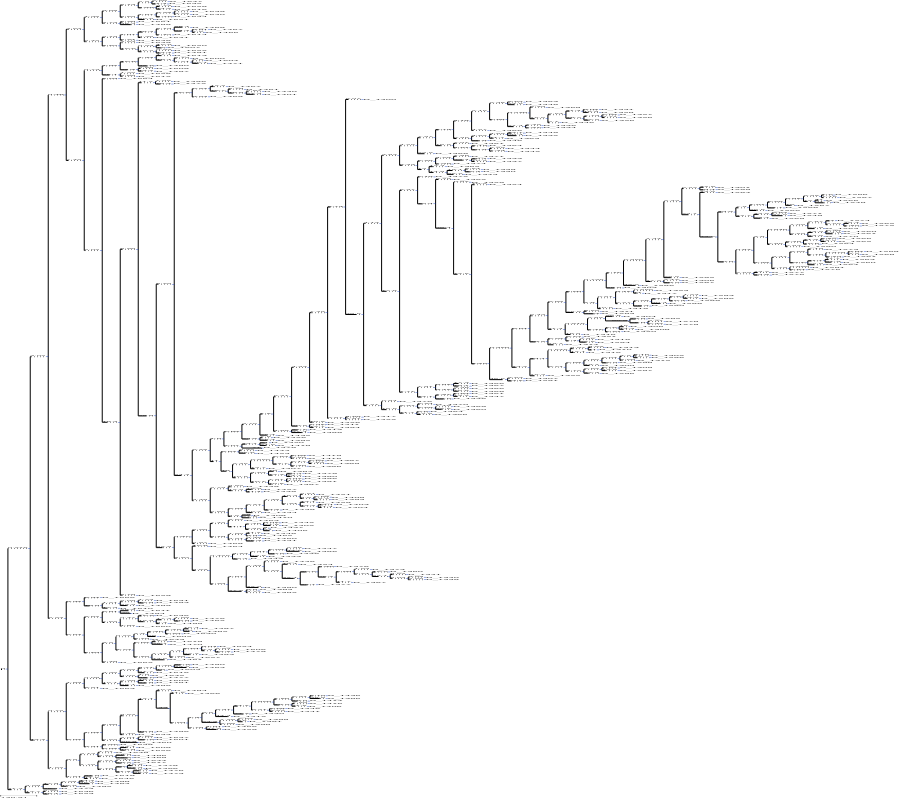

In [10]:
a_tree = Tree(forest[41])
ts = TreeStyle()
ts.show_branch_length = True
a_tree.render(file_name="%%inline", w=900,h=800, tree_style=ts)

In [11]:
print(len(a_tree.get_leaves()))

308


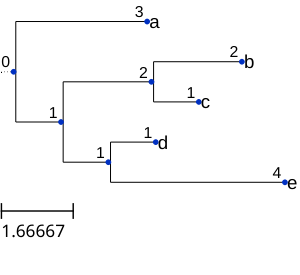

In [8]:
def rescale_tree(tree, target_avg_length=1):
    """
    Returns the rescaling factor and rescale the tree
    :params str_tree: string, newick tree on which we compute the rescaling factor is computed
    :params target_avg_length: float, the average branch length to which we want to rescale the tree
    :returns: float, resc_factor
    """    
    
    branch_lengths = [node.dist for node in tree.traverse()]
    resc_factor = np.mean(branch_lengths)/target_avg_length
    
    for node in tree.traverse():
        node.dist /= resc_factor
        
#     print(np.mean([node.dist for node in tree.traverse()]))
    
    return resc_factor


def ladderize(tre):
    """
    Tree ladderization: the branch supporting the most recently sampled subtree is rotated to the left
    :params tre: ete3 Tree, binary tree we want to ladderize
    :return: void, modified the tree tre
    """
    
    # feature to know which subtree is the most recent
    for node in tre.iter_descendants("postorder"):
        if node.is_leaf():
            node.add_feature('subtree_size', node.dist)
        else:
            children = node.children
            node.add_feature('subtree_size', node.dist + max(children[0].subtree_size, children[1].subtree_size))
            
    # swap children so that the most recent is on the left
    for node in tre.traverse():

        children = node.children #if node is leaf children==None
        if children:
            if children[0].subtree_size < children[1].subtree_size:
                node.swap_children()
                
    
            children[0].del_feature("subtree_size")
            children[1].del_feature("subtree_size")
            
            
def inorder_traverse(node, previous_node, vect_lf=[], vect_in=[]):
    """
    Tree traversal (standart recursive algorithm from the depth first family) and encoding
    Inorder tree walk (binary search tree)
    :param node: 
    :param previous_node:
    :param root:
    :param vect_lf:
    :param vect_in:
    :return: 
    """

    if node.is_root():
        node.add_feature('dist_to_root', 0)
        previous_depth = 0
    else:
        previous_depth = node.up.dist_to_root

    
    if not node.is_leaf(): # node has always 2 children, provided that it is not a leaf
        node.add_feature('dist_to_root', node.dist + previous_depth)
        
        inorder_traverse(node.children[0], previous_node, vect_lf=vect_lf, vect_in=vect_in)
        
        #for internal node, we add its distance to the root
        vect_in.append(node.dist_to_root)
        
        previous_node = node
        inorder_traverse(node.children[1], previous_node, vect_lf=vect_lf, vect_in=vect_in)
        
    else:
        #for tips, we add its distance to the previously visited node
        vect_lf.append(node.dist+previous_depth - previous_node.dist_to_root)

            
    return vect_lf, vect_in


def to_CBLV(tre, maxSize, sampling_p):
    """
    :param tree: ete3 tree, tree that we want to vectorize
    :param maxSize: int, dimension of the vector/NN input
    :return:
    """

    # Tree ladderization
    ladderize(tre)
    #print(tre.get_ascii("name"))
    # Get 
    # Encoding
    vect_lf, vect_in = inorder_traverse(tre, tre, vect_lf=[], vect_in=[])
    
    # Zero-completion
    tree_vect = np.zeros((2, maxSize))
    tree_vect[0, :len(vect_lf)] = vect_lf
    tree_vect[1, :len(vect_in)] = vect_in
    
    tree_vect[:, -1] = [sampling_p]*2
    
    return tree_vect

# Check algorithm
test_tree = Tree("(a:3,((b:2, c)C:2, (d, e:4)D)B)A;", format=1)
ts = TreeStyle()
ts.show_branch_length = True
test_tree.render(file_name="%%inline", w=300,tree_style=ts)

fact 1.6666666666666667


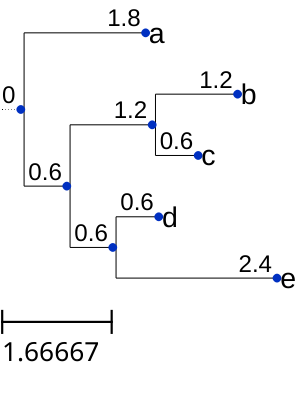

In [3]:
print('fact', rescale_tree(test_tree))
test_tree.render(file_name="%%inline", w=300,tree_style=ts)

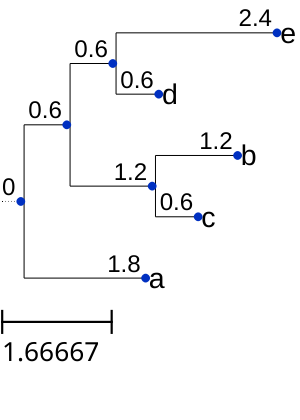

In [5]:
ladderize(test_tree)
test_tree.render(file_name="%%inline", w=300,tree_style=ts)

In [7]:
to_CBLV(test_tree, 8, 0.2).T

array([[3.6, 1.2],
       [0.6, 0.6],
       [2.4, 1.8],
       [0.6, 0. ],
       [1.8, 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0.2, 0.2]])

The corresponding Compact Bijective Ladderized Vector is:
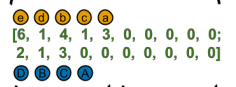

In [5]:
direc = "/home/ivati/montages_reseau/backup/TEST_DATA/"

def transform_raw_data(param_file=direc+"test_params.csv", trees_file=direc+"test_Trees.newick",
                       vectors_file=direc+"test_CBLV.npy", new_params_file=direc+"test_scaled_params.csv",
                       factors_file=direc+"test_factors.npy"):
    """
    Remove label that leads to no tree 
    Rescale time dependent parameters in design
    Rescale tree in forest and turn each tree into his CBLV REPRESENTATION
    """
    
    #Load files
    params = pd.read_table(param_file, sep=" ")
    with open(trees_file,'r') as f:
        forest = f.readlines()

    params_to_scale = ['mean_signal', 'incubation_rate', 'recovery_rate'] #bêta, gamma et sigma are time dependent
    data_vect = []
    resc_fact = []
    
    nb = len(forest)
    
    for i in range(nb):

        tree = Tree(forest[i])
        fact = rescale_tree(tree) # tree is rescaled
        
        resc_fact.append(fact) 
        params.loc[i][params_to_scale] *= fact #some time dependent parameters are scaled

        # stock CBLV representation
        data_vect.append(to_CBLV(tree, LARGE_SIZE, params.loc[i]['sampling_proba']))
            

    # Check shapes
    V = np.array(data_vect)
    F = np.array(resc_fact)
    print(V.shape)
    print(params.shape)
    print(F.shape)
    
    # save features and labels  

    np.save(vectors_file, V)
    params.to_csv(new_params_file)
    
    # save rescale factors
    np.save(factors_file, F)


st = time.time()
# small_vect, small_fact, small_param, large_vect, large_fact, large_param = transform_raw_data()
transform_raw_data()
print('Conversion took', (time.time()-st)/60, 'min')
# %snakeviz transform_raw_data()

(1142, 2, 901)
(1142, 6)
(1142,)
Conversion took 0.3106129765510559 min


In [ ]:
def transform_raw_data(param_file=path+"params_TiPS3.csv", trees_file=path+"Trees_TiPS3.newick",
                       vectors_file="CBLV3.npy", new_params_file="scaled_params3.csv",
                       factors_file="factors3.npy"):
    """
    Remove label that leads to no tree 
    Rescale time dependent parameters in design
    Rescale tree in forest and turn each tree into his CBLV REPRESENTATION
    """
    
    #Load files
    params = pd.read_table(param_file, sep=" ")
    with open(trees_file,'r') as f:
        forest = f.readlines()

    params_to_scale = ['mean_signal', 'incubation_rate', 'recovery_rate'] #bêta, gamma et sigma are time dependent
    small_data_vect, large_data_vect = [], []
    small_scaled_params, large_scaled_params = pd.DataFrame(columns=params.columns), pd.DataFrame(columns=params.columns)
    small_resc_fact, large_resc_fact = [], []
    
    nb = len(forest)
    
    for i in range(nb):

        tree = Tree(forest[i])
        resc_fact = rescale_tree(tree) # tree is rescaled
        
        if len(tree.get_leaves()) < SMALL_SIZE:
            small_resc_fact.append(resc_fact) 
            
            small_scaled_params.loc[i] = params.loc[i]
            small_scaled_params.loc[i][params_to_scale] *= resc_fact #some time dependent parameters are scaled

            # stock CBLV representation
            small_data_vect.append(to_CBLV(tree, SMALL_SIZE, params.loc[i]['sampling_proba']))
            
        else:
            large_resc_fact.append(resc_fact) 
            
            large_scaled_params.loc[i] = params.loc[i]
            large_scaled_params.loc[i][params_to_scale] *= resc_fact #some time dependent parameters are scaled

            # stock CBLV representation
            large_data_vect.append(to_CBLV(tree, LARGE_SIZE, params.loc[i]['sampling_proba']))

    # Check shapes
    print(np.array(small_data_vect).shape)
    print(small_scaled_params.shape)
    print(np.array(small_resc_fact).shape)
    print(np.array(large_data_vect).shape)
    print(large_scaled_params.shape)
    print(np.array(large_resc_fact).shape)
    
    # save features and labels  
    direc = "/home/ivati/montages_reseau/backup/"
    np.save(direc+"SMALL_DATA/small_"+vectors_file, np.array(small_data_vect))
    np.save(direc+"LARGE_DATA/large_"+vectors_file, np.array(large_data_vect))
    small_scaled_params.to_csv(direc+"SMALL_DATA/small_"+new_params_file)
    large_scaled_params.to_csv(direc+"LARGE_DATA/large_"+new_params_file)
    
    # save rescale factors
    np.save(direc+"SMALL_DATA/small_"+factors_file, np.array(small_resc_fact))
    np.save(direc+"LARGE_DATA/large_"+factors_file, np.array(large_resc_fact))



st = time.time()
# small_vect, small_fact, small_param, large_vect, large_fact, large_param = transform_raw_data()
transform_raw_data()
print('Conversion took', (time.time()-st)/60, 'min')
# %snakeviz transform_raw_data()

In [9]:
param_file=path+"test_params.csv"
trees_file=path+"test_Trees.newick"
# vectors_file=path+"4CBLV.npy"
# new_params_file=path+"4scaled_params.csv"
# factors_file=path+"4factors.npy"

params = pd.read_table(param_file, sep=" ")
print(len(params))
with open(trees_file,'r') as f:
    forest = f.readlines()
print(len(forest))

1399
1399


In [10]:
params_to_scale = ['mean_signal'] #bêta, gamma et sigma are time dependent
data_vect = []
resc_fact= []

nb = len(forest)

In [11]:
st = time.time()
for i in range(nb):

    tree = Tree(forest[i])
 
    fact = rescale_tree(tree) # tree is rescaled
    resc_fact.append(fact) 
    params.loc[i][params_to_scale] *= fact #some time dependent parameters are scaled

    # stock CBLV representation
    data_vect.append(to_CBLV(tree, SIZE, params.loc[i]['sampling_proba']))
print('Conversion took', (time.time()-st)/60, 'min')

Conversion took 0.17901240984598796 min


In [16]:
V = np.array(data_vect)
F = np.array(resc_fact)
print(V.shape)
print(F.shape)

(274119, 2, 600)
(274119,)


In [17]:
params

mean_signal  amplitude  import_param  sampling_proba
0          4.934910   0.507402     12.593693            0.02
1          4.514512   0.593478      8.226134            0.02
2          4.948742   0.234752     13.390961            0.02
3          5.493812   0.303758      5.418889            0.02
4          4.986793   0.347775     12.998521            0.02
...             ...        ...           ...             ...
274114     4.761220   0.377007      5.042012            0.02
274115     5.833348   0.271912      7.687018            0.02
274116     5.701865   0.251415     13.642798            0.02
274117     4.747969   0.421213      6.252080            0.02
274118     5.746581   0.162676      7.727706            0.02

[274119 rows x 4 columns]

In [10]:
np.max(V, axis=(0,2))

array([57.94457718, 56.66401349])

In [18]:
# save features and labels
np.save(vectors_file, np.array(V))
params.to_csv(new_params_file, index=False)

# save rescale factors
np.save(factors_file, F)